
# Drone Swarm Simulation Analysis (v3 - Multiple Modulations)

This notebook analyzes the output CSV file generated by the drone swarm simulation, now including data for multiple modulation schemes.<br>


It performs the following steps:
1. **Load Data**: Reads parameters and step-by-step simulation data from the CSV file.<br>
2. **Preprocess Data**:<br>
    - Separates simulation parameters from the main dataset.<br>
    - Converts relevant columns to appropriate numeric types, including multiple capacity columns (e.g., `bpsk_cap`, `qpsk_cap`) and `required_safety_capacity`.<br>
    - Filters for edges that are susceptible to Electronic Warfare (`is_ew_susceptible == True`).<br>
3. **Visualize Data**:<br>
    - For each capacity type (e.g., `theoretical_cap`, `bpsk_cap`, etc.):<br>
        - Plots the capacity of susceptible edges over simulation `steps`.<br>
        - For each plotted edge, a horizontal dashed line indicates its `required_safety_capacity`.<br>
        - Each susceptible edge is represented by a distinct colored line.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io # For reading the mixed-format CSV

In [12]:
sns.set_context("talk")


## 1. Load Data<br>
<br>

In [13]:
# Specify the path to the CSV file generated by the simulation.

csv_filepath = 'swarm_log_detailed_CROSS_ROW_len300_jam2_2624.csv'

In [14]:
def load_simulation_data(filepath):
    """Loads parameters and step data from the simulation CSV file."""
    parameters = {}
    data_lines = []
    with open(filepath, 'r') as f:
        reading_params = True
        header_line = None
        for line_num, line in enumerate(f):
            line = line.strip()
            if not line: # Blank line separates parameters from data header
                reading_params = False
                continue
            if reading_params:
                if ',' in line and not line.startswith('step,'): # Heuristic to avoid header
                    parts = line.split(',', 1)
                    if len(parts) == 2:
                        key, value = parts[0].strip(), parts[1].strip()
                        if value.lower() == 'true':
                            parameters[key] = True
                        elif value.lower() == 'false':
                            parameters[key] = False
                        elif value.startswith('(') and value.endswith(')'):
                            try:
                                parameters[key] = eval(value)
                            except:
                                parameters[key] = value
                        else:
                            try:
                                parameters[key] = float(value)
                            except ValueError:
                                parameters[key] = value
                    elif line_num == 0 and not any(k in line for k in ['step', 'leader_pos_x']):
                         parameters[line] = None
                elif line_num == 0 and not any(k in line for k in ['step', 'leader_pos_x']):
                     parameters[line] = None
            else:
                if header_line is None:
                    header_line = line
                    data_lines.append(header_line)
                else:
                    data_lines.append(line)
    if not data_lines or len(data_lines) < 2:
        raise ValueError("No data or only header found after parameters in the CSV file.")
    data_io = io.StringIO('\n'.join(data_lines))
    df = pd.read_csv(data_io)
    if 'Parameter' in parameters and parameters['Parameter'] == 'Value':
        del parameters['Parameter']
    return parameters, df

Load the data

In [15]:
try:
    sim_params, sim_df = load_simulation_data(csv_filepath)
    print("Simulation Parameters Loaded:")
    for key, value in sim_params.items():
        print(f"  {key}: {value}")
    print("\nFirst 5 rows of Simulation Data:")
    print(sim_df.head())
    print("\nDataframe Info:")
    sim_df.info()
except FileNotFoundError:
    print(f"Error: The file '{csv_filepath}' was not found. Please check the path.")
except ValueError as e:
    print(f"Error processing the CSV file: {e}")

Error: The file 'swarm_log_detailed_CROSS_ROW_len300_jam2_2624.csv' was not found. Please check the path.



## 2. Preprocess Data

Prepare the data for plotting:<br>
- Ensure correct data types for new capacity columns.<br>
- Filter for EW susceptible edges.<br>
- Create a unique edge label for plotting.

In [16]:
if 'sim_df' in locals(): # Check if DataFrame was loaded successfully
    # Correct data types for relevant columns
    sim_df['step'] = pd.to_numeric(sim_df['step'])
    sim_df['required_safety_capacity'] = pd.to_numeric(sim_df['required_safety_capacity'])
    sim_df['is_ew_susceptible'] = sim_df['is_ew_susceptible'].astype(bool)
    if 'bw_area' in sim_df.columns: # bw_area might not always be used for susceptibility
        sim_df['bw_area'] = pd.to_numeric(sim_df['bw_area'])

    # Identify capacity columns
    capacity_columns = ['theoretical_cap', 'bpsk_cap', 'qpsk_cap', '16qam_cap', '64qam_cap']
    
    # Convert capacity columns to numeric
    for cap_col in capacity_columns:
        if cap_col in sim_df.columns:
            sim_df[cap_col] = pd.to_numeric(sim_df[cap_col])
        else:
            print(f"Warning: Capacity column '{cap_col}' not found in DataFrame.")
            capacity_columns.remove(cap_col) # Remove if not found to avoid errors later
            
    # Filter for EW susceptible edges
    susceptible_df = sim_df[sim_df['is_ew_susceptible'] == True].copy()

    # Create a unique identifier for each edge to use in plotting
    if not susceptible_df.empty:
        susceptible_df['edge_label'] = susceptible_df.apply(lambda row: f"{row['edge_u']}-{row['edge_v']}", axis=1)
    print("\nFirst 5 rows of Preprocessed Susceptible Edges Data:")
    if susceptible_df.empty:
        print("No susceptible edges found. This might be normal if the jammer's BW area didn't match any edge or no edges were marked susceptible.")
    else:
        print(susceptible_df.head())
    print("\nSusceptible DataFrame Info:")
    susceptible_df.info()
else:
    print("DataFrame 'sim_df' not loaded. Cannot preprocess.")

DataFrame 'sim_df' not loaded. Cannot preprocess.


## 3. Visualize Data

### Plot each modulation seperately

For each capacity type (e.g., BPSK, QPSK), plot its value against `step` for each susceptible edge.<br>
A horizontal line will indicate the `required_safety_capacity` for that specific edge (this threshold is the same for all capacity types of a given edge).

In [17]:
if 'susceptible_df' in locals() and not susceptible_df.empty and 'capacity_columns' in globals() and capacity_columns:
    unique_edges = susceptible_df['edge_label'].unique()
    palette = sns.color_palette('husl', n_colors=len(unique_edges)) # Palette based on number of unique edges

    for cap_col_name in capacity_columns: # Outer loop for each modulation type
        plt.figure(figsize=(18, 10)) # New figure for this modulation type

        for i, edge_label_str in enumerate(unique_edges): # Inner loop for each unique edge
            edge_data = susceptible_df[susceptible_df['edge_label'] == edge_label_str]

            if edge_data.empty or cap_col_name not in edge_data.columns:
                continue

            # 1. Plot capacity line for the current edge and modulation type
            # Assign label directly for the legend, using only the edge identifier.
            plt.plot(edge_data['step'], edge_data[cap_col_name], marker='.', linestyle='-',
                     color=palette[i], label=edge_label_str)
            
            # 2. Plot safety threshold line for the current edge
            # No label is assigned here, so it won't appear in the legend.
            safety_threshold_for_edge = edge_data['required_safety_capacity'].iloc[0]
            plt.axhline(y=safety_threshold_for_edge, color=palette[i], linestyle='--', alpha=0.7)

        # --- Settings for the current modulation plot (after all edges are plotted) ---
        plt.title(f'{cap_col_name.replace("_", " ").title()} of Susceptible Edges Over Time vs. Safety Thresholds')
        plt.xlabel('Simulation Step')
        plt.ylabel(f'Network Capacity ({cap_col_name.split("_")[0].upper() if "_" in cap_col_name else cap_col_name}, bits/sec)')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Legend creation:
        # Get handles and labels automatically from labeled lines.
        handles, labels = plt.gca().get_legend_handles_labels()
        # Use a dictionary to ensure unique legend entries (in case of any accidental duplication)
        by_label = dict(zip(labels, handles))
        
        if by_label: # Check if there are any items for the legend
            plt.legend(by_label.values(), by_label.keys(), title='Edges', bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            # Optionally, show an empty legend box or no legend if nothing was plotted with a label
            plt.legend(title='Edges', bbox_to_anchor=(1.05, 1), loc='upper left')


        plt.tight_layout(rect=[0, 0, 0.80, 1]) # Adjust layout to make space for legend
        plt.yscale('log') # Use log scale if capacities vary widely
        # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) # Optional: scientific notation
        
        plt.show() # Show the plot for the current modulation type

elif 'susceptible_df' in locals() and susceptible_df.empty:
    print("No susceptible edges were found in the data (is_ew_susceptible was always False).")
    print("This could mean the jammer's selected BW area did not match any edge's BW area, or no edges were marked as susceptible.")
    print("Check the 'EW_JAMMER_ACTUAL_BW_AREA' parameter, edge 'bw_area' values, and 'is_ew_susceptible' column.")
elif not ('capacity_columns' in globals() and capacity_columns):
    print("No capacity columns were identified for plotting. Please check column names in the CSV and script.")
else:
    print("No susceptible edge data to plot or 'susceptible_df' not created.")
    

No capacity columns were identified for plotting. Please check column names in the CSV and script.


### Plot each edge seperately

In [18]:
if 'susceptible_df' in locals() and not susceptible_df.empty and 'capacity_columns' in globals() and capacity_columns:
    unique_edges = susceptible_df['edge_label'].unique()
    palette = sns.color_palette('tab10', n_colors=len(capacity_columns))  # Color palette for modulations

    for edge_label_str in unique_edges:  # Outer loop for each unique edge
        edge_data = susceptible_df[susceptible_df['edge_label'] == edge_label_str]

        if edge_data.empty:
            continue

        plt.figure(figsize=(18, 10))  # New figure for each edge

        for i, cap_col_name in enumerate(capacity_columns):  # Inner loop for each modulation type
            if cap_col_name not in edge_data.columns:
                continue

            # 1. Plot capacity line for the current modulation type
            plt.plot(edge_data['step'], edge_data[cap_col_name], marker='.', linestyle='-',
                     color=palette[i], label=cap_col_name.replace('_', ' ').title())

        # 2. Plot safety threshold line for the current edge (only one, independent of modulation)
        safety_threshold = edge_data['required_safety_capacity'].iloc[0]
        plt.axhline(y=safety_threshold, color='black', linestyle='--', alpha=0.8, label='Safety Threshold')

        # --- Settings for the current edge plot ---
        plt.title(f'Capacity Over Time for Edge {edge_label_str} vs. Safety Threshold')
        plt.xlabel('Simulation Step')
        plt.ylabel('Network Capacity (bits/sec)')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend(title='Modulation Types', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 0.80, 1])
        plt.yscale('log')  # Optional depending on data spread
        plt.show()

elif 'susceptible_df' in locals() and susceptible_df.empty:
    print("No susceptible edges were found in the data (is_ew_susceptible was always False).")
    print("This could mean the jammer's selected BW area did not match any edge's BW area, or no edges were marked as susceptible.")
    print("Check the 'EW_JAMMER_ACTUAL_BW_AREA' parameter, edge 'bw_area' values, and 'is_ew_susceptible' column.")
elif not ('capacity_columns' in globals() and capacity_columns):
    print("No capacity columns were identified for plotting. Please check column names in the CSV and script.")
else:
    print("No susceptible edge data to plot or 'susceptible_df' not created.")


No capacity columns were identified for plotting. Please check column names in the CSV and script.


## Simulation runs Grid search analysis

Configure modulation

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import itertools

# Set Seaborn style
sns.set_style("whitegrid")
sns.set_context("talk")

# Load the dataset
df = pd.read_csv('results/grid_summary_parallel.csv')

# Configuration for modulation (change to 'BPSK', 'QPSK', '16QAM', '64QAM', or 'THEORETICAL')
MODULATION = 'BPSK'  # Change this to the desired modulation type

# Handle NaN for THEORETICAL modulation
if MODULATION == 'THEORETICAL':
    df = df[df['num_disconnected_susceptible_links'] >= 1].copy()

# Define columns for R1 and R2 based on modulation
r1_col = f'r1_{MODULATION.lower()}_m'
r2_col = f'r2_{MODULATION.lower()}_m'

# Debugging: Check data before dropping NaN
print(f"Initial data shape: {df.shape}")
print("Unique LINK_LENGTH_METERS:", sorted(df['LINK_LENGTH_METERS'].unique()))
print("Unique relay_connectivity_config:", df['relay_connectivity_config'].unique())
print("Unique network_capacity_type:", df['network_capacity_type'].unique())

# Ensure no NaN in R1 and R2 columns for selected modulation
df = df.dropna(subset=[r1_col, r2_col])

# Debugging: Check data after dropping NaN
print(f"Data shape after dropna: {df.shape}")
print("Value counts for combinations:")
print(df[['LINK_LENGTH_METERS', 'relay_connectivity_config', 'network_capacity_type']].value_counts().sort_index())

# Define parameters
connectivity_configs = ['MINIMAL', 'CROSS_ROW', 'ALL_CONNECT']
network_capacities = ['SMALL', 'MEDIUM', 'LARGE']
link_lengths = sorted(df['LINK_LENGTH_METERS'].unique())

# Create color palettes
connectivity_colors = sns.color_palette("deep", n_colors=len(connectivity_configs))
capacity_colors = sns.color_palette("muted", n_colors=len(network_capacities))
connectivity_color_map = dict(zip(connectivity_configs, connectivity_colors))
capacity_color_map = dict(zip(network_capacities, capacity_colors))


Initial data shape: (1080, 21)
Unique LINK_LENGTH_METERS: [np.int64(10), np.int64(20), np.int64(30), np.int64(40), np.int64(50), np.int64(60), np.int64(70), np.int64(80), np.int64(90), np.int64(100), np.int64(110), np.int64(120), np.int64(130), np.int64(140), np.int64(150), np.int64(160), np.int64(170), np.int64(180), np.int64(190), np.int64(200), np.int64(210), np.int64(220), np.int64(230), np.int64(240), np.int64(250), np.int64(260), np.int64(270), np.int64(280), np.int64(290), np.int64(300)]
Unique relay_connectivity_config: ['MINIMAL' 'CROSS_ROW' 'ALL_CONNECT']
Unique network_capacity_type: ['SMALL' 'MEDIUM' 'LARGE']
Data shape after dropna: (1080, 21)
Value counts for combinations:
LINK_LENGTH_METERS  relay_connectivity_config  network_capacity_type
10                  ALL_CONNECT                LARGE                    4
                                               MEDIUM                   4
                                               SMALL                    4
             

### Plot 1: R1 and R2 vs. Link Length by Network Capacity and Connectivity

Grouped data shape: (270, 5)
Missing values in grouped data:
r1_bpsk_m    0
r2_bpsk_m    0
dtype: int64
Combinations with NaN in r1 or r2:
Empty DataFrame
Columns: [LINK_LENGTH_METERS, relay_connectivity_config, network_capacity_type]
Index: []


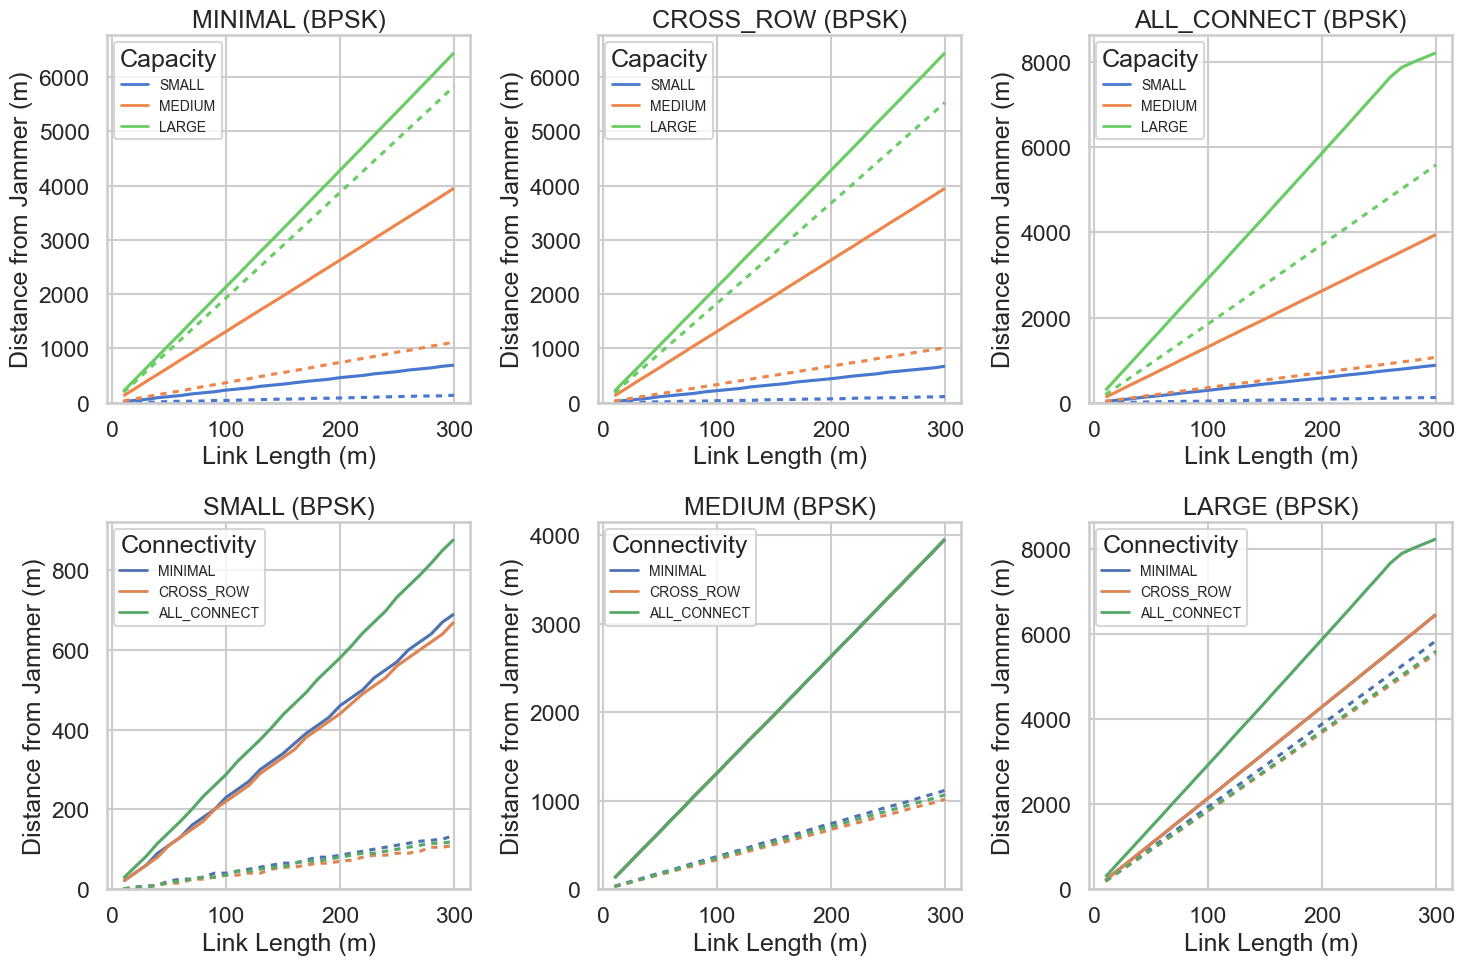

In [86]:
# Prepare data for line plots by averaging across EW_JAMMER_ACTUAL_BW_AREA
plot1_data = df.groupby(['LINK_LENGTH_METERS', 'relay_connectivity_config', 'network_capacity_type'])[[r1_col, r2_col]].mean().reset_index()

# Create all possible combinations of LINK_LENGTH_METERS, relay_connectivity_config, and network_capacity_type
all_combinations = pd.DataFrame(
    list(itertools.product(link_lengths, connectivity_configs, network_capacities)),
    columns=['LINK_LENGTH_METERS', 'relay_connectivity_config', 'network_capacity_type']
)

# Merge with plot1_data to ensure all combinations are included
plot1_data = all_combinations.merge(
    plot1_data,
    on=['LINK_LENGTH_METERS', 'relay_connectivity_config', 'network_capacity_type'],
    how='left'
)

# Debugging: Check for missing data
print("Grouped data shape:", plot1_data.shape)
print("Missing values in grouped data:")
print(plot1_data[[r1_col, r2_col]].isna().sum())
print("Combinations with NaN in r1 or r2:")
print(plot1_data[plot1_data[r1_col].isna() | plot1_data[r2_col].isna()][['LINK_LENGTH_METERS', 'relay_connectivity_config', 'network_capacity_type']])

# Melt data for Seaborn plotting (R1 and R2 as a single column)
plot1_data_melted = pd.melt(
    plot1_data,
    id_vars=['LINK_LENGTH_METERS', 'relay_connectivity_config', 'network_capacity_type'],
    value_vars=[r1_col, r2_col],
    var_name='Metric',
    value_name='Distance'
)

# Plot 1: R1 and R2 vs. Link Length by Network Capacity and Connectivity
plt.figure(figsize=(15, 10))

# First row: Subplots for each relay_connectivity_config
for i, config in enumerate(connectivity_configs, 1):
    plt.subplot(2, 3, i)
    subset = plot1_data_melted[plot1_data_melted['relay_connectivity_config'] == config]
    for cap in network_capacities:
        cap_subset = subset[subset['network_capacity_type'] == cap]
        sns.lineplot(
            data=cap_subset,
            x='LINK_LENGTH_METERS',
            y='Distance',
            hue='network_capacity_type',
            style='Metric',
            palette=capacity_color_map,
            dashes={'r1_' + MODULATION.lower() + '_m': (1, 0), 'r2_' + MODULATION.lower() + '_m': (2, 2)},
            legend=False  # Disable automatic legend
        )
    plt.title(f'{config} ({MODULATION})')
    plt.xlabel('Link Length (m)')
    plt.ylabel('Distance from Jammer (m)')
    plt.ylim(bottom=0)
    # Custom legend for network_capacity_type only
    legend_elements = [Line2D([0], [0], color=capacity_color_map[cap], lw=2, label=cap) 
                       for cap in network_capacities]
    plt.legend(handles=legend_elements, title='Capacity', fontsize=10)

# Second row: Subplots for each network_capacity_type
for i, cap in enumerate(network_capacities, 1):
    plt.subplot(2, 3, i + 3)
    subset = plot1_data_melted[plot1_data_melted['network_capacity_type'] == cap]
    for config in connectivity_configs:
        config_subset = subset[subset['relay_connectivity_config'] == config]
        sns.lineplot(
            data=config_subset,
            x='LINK_LENGTH_METERS',
            y='Distance',
            hue='relay_connectivity_config',
            style='Metric',
            palette=connectivity_color_map,
            dashes={'r1_' + MODULATION.lower() + '_m': (1, 0), 'r2_' + MODULATION.lower() + '_m': (2, 2)},
            legend=False  # Disable automatic legend
        )
    plt.title(f'{cap} ({MODULATION})')
    plt.xlabel('Link Length (m)')
    plt.ylabel('Distance from Jammer (m)')
    plt.ylim(bottom=0)
    # Custom legend for relay_connectivity_config only
    legend_elements = [Line2D([0], [0], color=connectivity_color_map[config], lw=2, label=config) 
                       for config in connectivity_configs]
    plt.legend(handles=legend_elements, title='Connectivity', fontsize=10)

plt.tight_layout()
plt.show()


### Plot 2: R1 vs. R2 by Network Capacity


C:\Users\sante\AppData\Local\Temp\ipykernel_8876\3845203469.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
C:\Users\sante\AppData\Local\Temp\ipykernel_8876\3845203469.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Connectivity', fontsize=10)


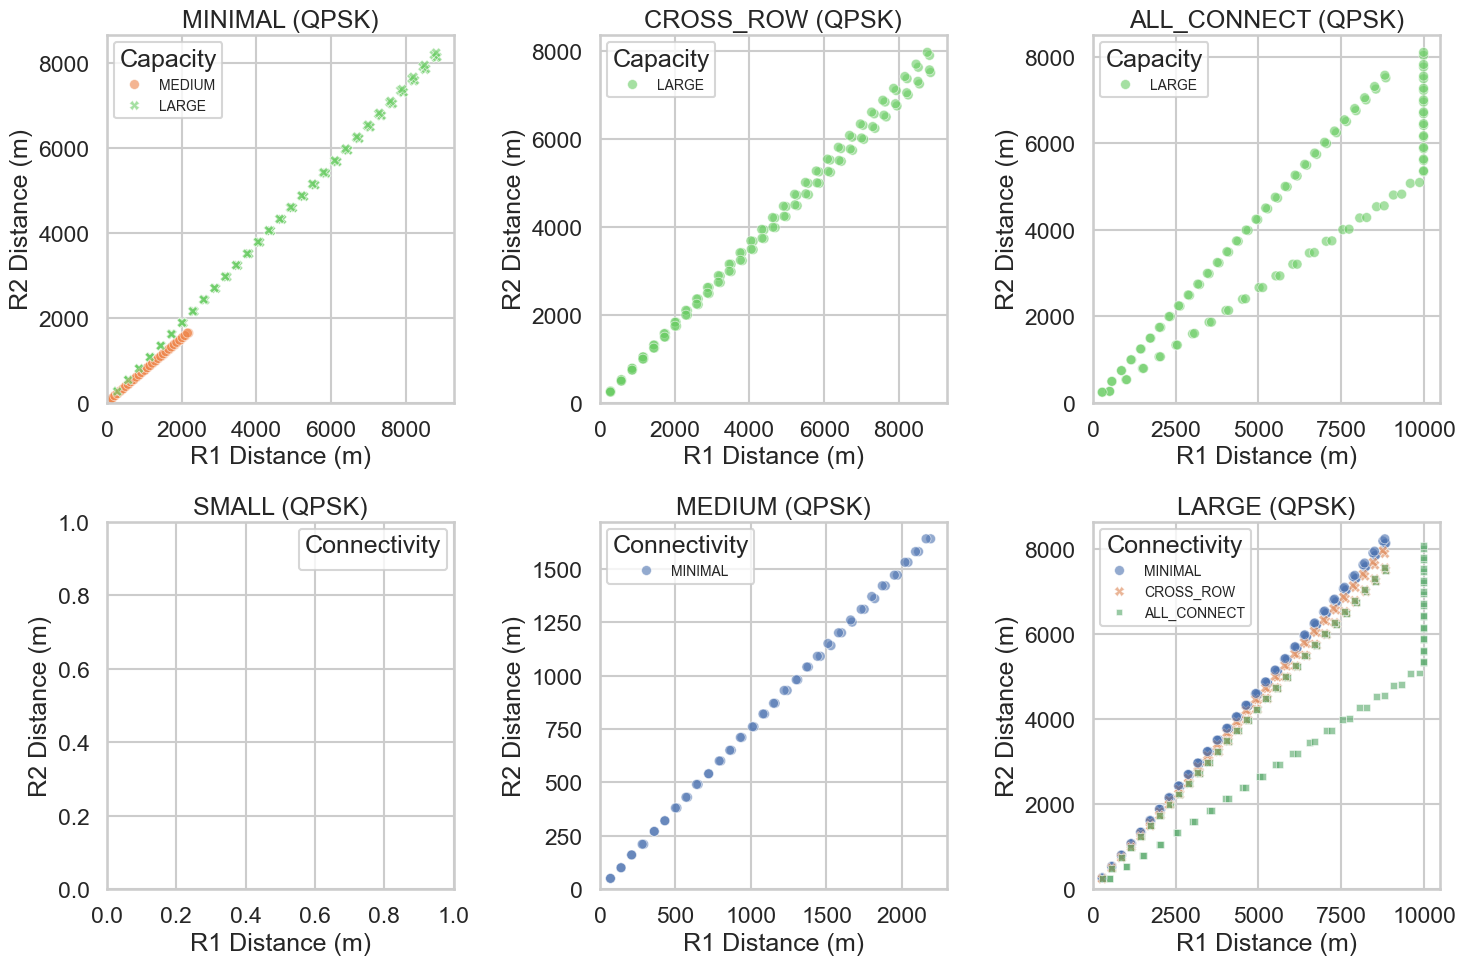

In [57]:
plt.figure(figsize=(15, 10))

# First row: Subplots for each relay_connectivity_config
for i, config in enumerate(connectivity_configs, 1):
    plt.subplot(2, 3, i)
    subset = df[df['relay_connectivity_config'] == config]
    sns.scatterplot(
        data=subset,
        x=r1_col,
        y=r2_col,
        hue='network_capacity_type',
        style='network_capacity_type',
        palette=capacity_color_map,
        s=50,
        alpha=0.6
    )
    plt.title(f'{config} ({MODULATION})')
    plt.xlabel('R1 Distance (m)')
    plt.ylabel('R2 Distance (m)')
    plt.legend(title='Capacity', fontsize=10)
    plt.xlim(left=0)
    plt.ylim(bottom=0)

# Second row: Subplots for each network_capacity_type
for i, cap in enumerate(network_capacities, 1):
    plt.subplot(2, 3, i + 3)
    subset = df[df['network_capacity_type'] == cap]
    sns.scatterplot(
        data=subset,
        x=r1_col,
        y=r2_col,
        hue='relay_connectivity_config',
        style='relay_connectivity_config',
        palette=connectivity_color_map,
        s=50,
        alpha=0.6
    )
    plt.title(f'{cap} ({MODULATION})')
    plt.xlabel('R1 Distance (m)')
    plt.ylabel('R2 Distance (m)')
    plt.legend(title='Connectivity', fontsize=10)
    plt.xlim(left=0)
    plt.ylim(bottom=0)

plt.tight_layout()
plt.show()


### Plot 3: Average R1 and R2 by Modulation Type

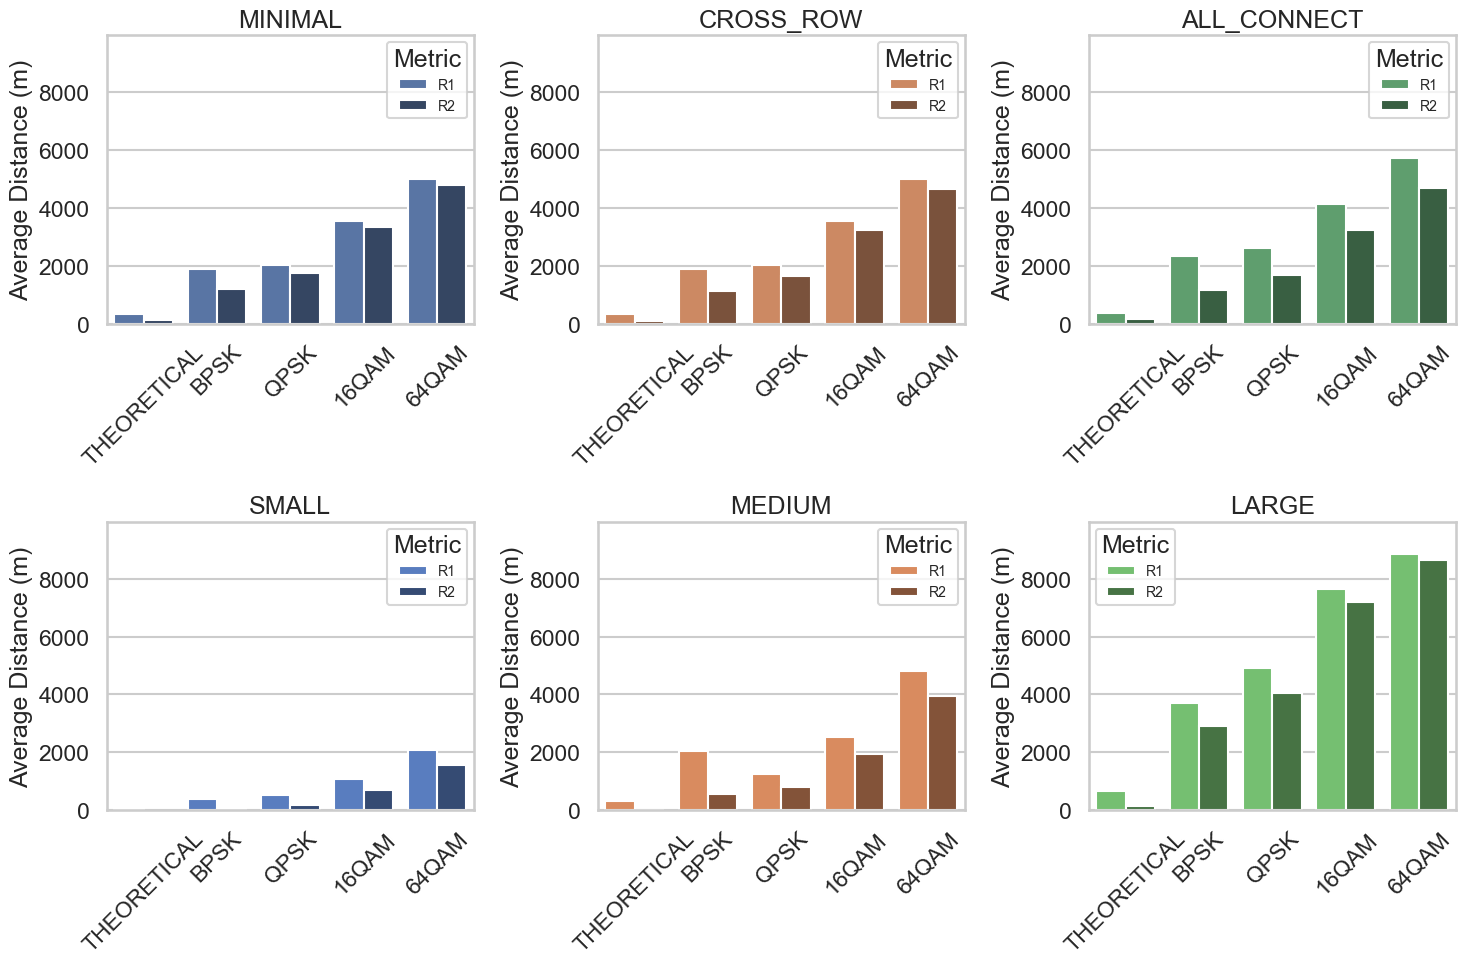

In [87]:
modulations = ['THEORETICAL', 'BPSK', 'QPSK', '16QAM', '64QAM']
plt.figure(figsize=(15, 10))

# Prepare data for bar plot
bar_data = []
for mod in modulations:
    temp_df = df if mod != 'THEORETICAL' else df[df['num_disconnected_susceptible_links'] >= 1]
    for config in connectivity_configs:
        for cap in network_capacities:
            subset = temp_df[(temp_df['relay_connectivity_config'] == config) & 
                            (temp_df['network_capacity_type'] == cap)]
            r1_mean = subset[f'r1_{mod.lower()}_m'].mean()
            r2_mean = subset[f'r2_{mod.lower()}_m'].mean()
            bar_data.append({
                'Modulation': mod,
                'Connectivity': config,
                'Capacity': cap,
                'Metric': 'R1',
                'Distance': r1_mean
            })
            bar_data.append({
                'Modulation': mod,
                'Connectivity': config,
                'Capacity': cap,
                'Metric': 'R2',
                'Distance': r2_mean
            })
bar_df = pd.DataFrame(bar_data)

# Determine fixed y-axis limit
max_distance = bar_df['Distance'].max()
y_max = max_distance * 1.1  # Add 10% buffer for visibility

# First row: Subplots for each relay_connectivity_config
for i, config in enumerate(connectivity_configs, 1):
    plt.subplot(2, 3, i)
    subset = bar_df[bar_df['Connectivity'] == config]
    sns.barplot(
        data=subset,
        x='Modulation',
        y='Distance',
        hue='Metric',
        palette={'R1': connectivity_color_map[config], 'R2': tuple(x * 0.6 for x in connectivity_color_map[config])},
        dodge=True,
        errorbar=None  # Remove error bars
    )
    plt.title(f'{config}')
    plt.gca().set_xlabel('')
    plt.ylabel('Average Distance (m)')
    plt.xticks(rotation=45)
    plt.legend(title='Metric', fontsize=10)
    plt.ylim(0, y_max)  # Fixed y-axis

# Second row: Subplots for each network_capacity_type
for i, cap in enumerate(network_capacities, 1):
    plt.subplot(2, 3, i + 3)
    subset = bar_df[bar_df['Capacity'] == cap]
    sns.barplot(
        data=subset,
        x='Modulation',
        y='Distance',
        hue='Metric',
        palette={'R1': capacity_color_map[cap], 'R2': tuple(x * 0.6 for x in capacity_color_map[cap])},
        dodge=True,
        errorbar=None  # Remove error bars
    )
    plt.title(f'{cap}')
    plt.gca().set_xlabel('')
    plt.ylabel('Average Distance (m)')
    plt.xticks(rotation=45)
    plt.legend(title='Metric', fontsize=10)
    plt.ylim(0, y_max)  # Fixed y-axis

plt.tight_layout()
plt.show()
